## SIMS(Similar Items): Collaborative Filtering Based Recommendation
- 유저의 행동 정보 기반으로 유사한 아이템을 찾아 추천에 제공  
- 관심 상품을 클릭했을 때 동시에 등장하는 아이템들을 추천해주는 기능
- 컨텐츠 기반이 아님
- https://www.youtube.com/watch?v=dczs8cORHhg&t=463s 8분 14초 참고


# AWS personalize의 evaluation strategy

Personalize calculates these metrics based on a subset of the training data.  
The image below illustrates how Personalize splits the data.  
Given 10 users, with 10 interactions each (a circle represents an interaction), the interactions are ordered from oldest to newest based on the timestamp.  
Personalize uses all of the interaction data from 90% of the users (blue circles) to train the solution version, and the remaining 10% for evaluation.  
For each of the users in the remaining 10%, 90% of their interaction data (green circles) is used as input for the call to the trained model.  
The remaining 10% of their data (orange circle) is compared to the output produced by the model and used to calculate the evaluation metrics. 

Personalize는 이 메트릭을 학습 데이터셋의 일부분으로 계산함.  
10명의 유저가 있을 때, 10개의 상호작용이 있음. 시간순으로 가장 오래된 것부터 새로운 것까지 순서대로 나열됨.  
Personalize는 솔루션 버전을 학습하기 위해 전체 유저의 90% 수의 전체 인터랙션을 사용함. 그리고 나머지 10%를 사용해 평가를 진행함.  
남아있는 10%의 유저 각각에 대해, 90%의 인터렉션 데이터는 입력으로 사용되어 학습된 모델의 호출에 쓰임.  
나머지 10%의 데이터는 모델에 의해 생성된 출력 결과와 비교되어 평가 지표를 계산하는데 사용됨.  

In [6]:
# 필요한 컴포넌트 정의

# CF 적용을 위해 데이터 프레임 가공
# train/test split  + test interaction split

In [7]:
import pandas as pd
import numpy as np
import io
import scipy.sparse as ss
import json
import time
import datetime
import os

### 0) set configs

In [8]:
data_dir = "../../../data/aws_personalize/"

In [9]:
user_id="USER_ID"
item_id="ITEM_ID"


### 1) Load Processed interaction df

In [10]:
import joblib

In [11]:
a_interactions_df=joblib.load(data_dir+"a_interaction_df.pkl")

In [12]:
# 극심한 long tail (전체 25000명 중 4000명만이 2건 이상의 interaction 기록)
a_interactions_df.USER_ID.value_counts()[a_interactions_df.USER_ID.value_counts()>1]

AndersPedersen    58
TerconBojan       54
JBacallado        51
DGraubard         46
RogerStone        45
                  ..
AidanClarke        2
SDelrio            2
RajanBulchand      2
MBuenk             2
SGold              2
Name: USER_ID, Length: 4069, dtype: int64

<AxesSubplot:>

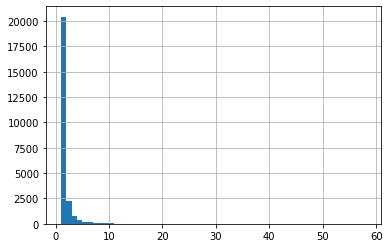

In [13]:
# histogram
a_interactions_df.USER_ID.value_counts().hist(bins=58)

### 2) filter out users with few interactions

In [14]:
# 오직 1건의 인터렉션만을 갖는 유저를 배제 

available_user_list=a_interactions_df.USER_ID.value_counts()[a_interactions_df.USER_ID.value_counts()>1].index.tolist()

available_user_interactions=a_interactions_df[a_interactions_df.USER_ID.isin(available_user_list)]

In [15]:
available_user_interactions=available_user_interactions.reset_index(drop=True)

In [16]:
item_dict=dict(zip(available_user_interactions.ITEM_ID.unique(),range(len(available_user_interactions.ITEM_ID.unique()))))

user_dict=dict(zip(available_user_interactions.USER_ID.unique(),range(len(available_user_interactions.USER_ID.unique()))))

In [140]:
item_dict_reverse=dict(zip(range(len(available_user_interactions.ITEM_ID.unique())), available_user_interactions.ITEM_ID.unique()))

user_dict_reverse=dict(zip(range(len(available_user_interactions.USER_ID.unique())), available_user_interactions.USER_ID.unique()))

In [17]:
# test는 20% save를 위해 5건 이상 인터렉션이 있는 유저로부터 ...
test_candidate_ids=available_user_interactions.USER_ID.value_counts()[available_user_interactions.USER_ID.value_counts()>=5].index.tolist()

# test 대상 유저의 수는 전체 가용 인원의 10%
test_user_num=round(len(available_user_list)/10)

In [18]:
import random

test_user_ids=random.sample(test_candidate_ids, test_user_num)

In [19]:
train_user_ids=list(set(available_user_list)-set(test_user_ids))

In [20]:
print(len(train_user_ids))
print(len(test_user_ids))

3662
407


In [21]:
train_df=available_user_interactions[available_user_interactions.USER_ID.isin(train_user_ids)]
test_df=available_user_interactions[available_user_interactions.USER_ID.isin(test_user_ids)]

In [22]:
test_df_for_test=test_df.groupby("USER_ID").apply(lambda x: x.sample(frac=0.2))

test_df_for_test=test_df_for_test.drop("USER_ID",axis=1).reset_index()

test_df_for_test=test_df_for_test.set_index("level_1")

test_df_for_train=test_df[~(test_df.index.isin(test_df_for_test.index))]

In [23]:
total_train_df=pd.concat([train_df, test_df_for_train])

In [24]:
total_train_df["ITEM_IDX"]=total_train_df['ITEM_ID'].map(item_dict)

total_train_df["USER_IDX"]=total_train_df['USER_ID'].map(user_dict)

In [25]:
test_df_for_test["ITEM_IDX"]=test_df_for_test['ITEM_ID'].map(item_dict)

test_df_for_test["USER_IDX"]=test_df_for_test['USER_ID'].map(user_dict)

In [26]:
# collaborative filtering implementation
# https://www.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/

In [27]:
n_users=available_user_interactions.USER_ID.nunique()

In [28]:
n_items=available_user_interactions.ITEM_ID.nunique()

In [29]:
interaction_matrix = np.zeros((n_users, n_items))

for row in total_train_df.itertuples():
    interaction_matrix[row[-1], row[-2]] = row[-4]
    

In [30]:
test_interaction_matrix=np.zeros((n_users, n_items))

for row in test_df_for_test.itertuples():
    test_interaction_matrix[row[-1], row[-2]] = row[-4]

In [31]:
interaction_matrix.shape

(4069, 322)

In [32]:
test_interaction_matrix.shape

(4069, 322)

In [33]:
import time
from scipy.sparse.linalg import svds


In [104]:
start=time.time()

U, sig , Vt =svds(interaction_matrix,k=3)

print(f"training time: {time.time()-start}s")

sig=np.diag(sig)

MF_train_predict=np.dot(np.dot(U,sig),Vt)# + interaction_matrix.reshape(-1,1)

training time: 0.2869298458099365s


In [164]:
MF_train_predict.shape

(4069, 322)

In [105]:
subtract_bought_items=np.where(interaction_matrix==0,0,np.inf)

In [106]:
MF_train_predict=np.subtract(MF_train_predict, subtract_bought_items)

In [107]:
test_index=[]
for user_name in test_user_ids:
    test_index.append(user_dict[user_name])

In [108]:
test_index=sorted(test_index)

In [109]:
test_user_similarity=MF_train_predict[test_index,:]

In [110]:
test_user_groundtruth=test_interaction_matrix[test_index,:]

# evaluate

In [111]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import sys
import scipy
import bottleneck as bn
import math
import os

def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=10):
    '''
    normalized discounted cumulative gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    '''
    batch_users = X_pred.shape[0]

    # bn.argpartition
    # kth 번째까지 등장하는 원소들이 리스트 내부에서 가장 작은 kth번째 원소들이도록 partition해주는 인덱스 리스트를 출력해줌.
    # 여기서는 -를 취해줬으므로, k번째까지 등장하는 원소들이 리스트 내부에서 가장 큰 100번째 원소들이도록 partition해주는 인덱스 리스트를 출력.

    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)

    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],idx_topk_part[:, :k]]

    # np.argsort -> sorting한 리스트의 arg를 뱉어냄. 
    # -를 붙여줌으로써 내림차순으로 정리(높은 놈이 위에)
    idx_part = np.argsort(-topk_part, axis=1)

    # X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk] is the sorted

    # topk predicted score
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    # build the discount template
    tp = 1. / np.log2(np.arange(2, k + 2))

    DCG_filter=(heldout_batch[np.arange(batch_users)[:, np.newaxis],idx_topk]>0)

    DCG = (DCG_filter * tp).sum(axis=1)


    # sparse matrix 내에서, 고객의 총 interaction 수와 k 중 더 작은 것을 골라서 IDCG 계산
    IDCG = np.array([(tp[:min(len(n.nonzero()[0]), k)]).sum() for n in heldout_batch])
    return DCG / IDCG


# In[2]:


def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0)
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
    return recall

In [112]:
Recall_at_k_batch(test_user_similarity, test_user_groundtruth, 10).mean()

0.11544401544401543

In [113]:
NDCG_binary_at_k_batch(test_user_similarity, test_user_groundtruth, 10).mean()

0.07264587160469828

# 결과 살펴보기

In [137]:
idx_number=15

In [137]:
sample_groundtruth=test_user_groundtruth[idx_number]

# filter out reviews with less than 5 point
sample_groundtruth=np.where(sample_groundtruth>=5,sample_groundtruth,0)

groundtruth_len=sample_groundtruth.nonzero()[0].shape[0]

groundtruth_sorted_index=np.argsort(sample_groundtruth)[::-1][:groundtruth_len]

groundtruth=[]
for review in groundtruth_sorted_index:
    groundtruth.append(item_dict_reverse[review])

In [159]:
groundtruth

['aegean-airlines',
 'tap-portugal',
 'lot-polish-airlines',
 'lufthansa',
 'swiss-international-air-lines']

In [157]:
sample_recomms=test_user_similarity[idx_number]
recomms_sorted_index=np.argsort(sample_recomms)[::-1][:25]

recomms=[]
for rec in recomms_sorted_index:
    recomms.append(item_dict_reverse[rec])

In [158]:
recomms

['singapore-airlines',
 'thai-airways',
 'easyjet',
 'qatar-airways',
 'ana-all-nippon-airways',
 'bangkok-airways',
 'air-canada',
 'asiana-airlines',
 'cathay-pacific-airways',
 'sas-scandinavian-airlines',
 'delta-air-lines',
 'eva-air',
 'korean-air',
 'jet-airways',
 'malaysia-airlines',
 'ryanair',
 'airasia',
 'american-airlines',
 'silkair',
 'brussels-airlines',
 'british-airways',
 'air-berlin',
 'south-african-airways',
 'garuda-indonesia',
 'lan-airlines']